In [1]:
# import
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import warnings
import datetime
from copy import deepcopy
from diffusion_crt import *

def transform(x):
    return torch.log(x)-torch.log(1-x)

def re_transform(x):
    return 1/(1+torch.exp(-x))

def inverse_to_original(z, x_min, x_max):
    # Step 1: inverse logit
    u = 1 / (1 + torch.exp(-z))

    # Step 2: undo division by 1.02
    x_norm = u * 1.02

    # Step 3: undo +0.01 shift
    x_scaled = x_norm - 0.01

    # Step 4: undo min-max normalization
    x_original = x_scaled * (x_max - x_min) + x_min

    return x_original

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(999)

In [3]:
#data gen and plot
sns.set()
plt.rcParams['figure.figsize'] = (24, 18)        
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
dz=5
num = 500 



dataset_x=torch.randn((num,dz))
U=np.random.binomial(n=1,p=0.5,size=num).reshape(num,1) 
U=torch.from_numpy(U)
rv_epsilon=np.zeros(shape=(num,1))
for i in range(0,len(U)):
    if U[i]<0.5:
        rv_epsilon[i]=np.random.normal(-2,1)
    else:
        rv_epsilon[i]=np.random.normal(2,1)
rv_epsilon=torch.from_numpy(rv_epsilon)
        
dataset_y=(5+dataset_x[:,0:1]**2/3+dataset_x[:,1:2]**2+dataset_x[:,2:3]**2+
           dataset_x[:,3:4]+dataset_x[:,4:5])*torch.exp(0.5*rv_epsilon)





device = torch.device('cuda')
dataset_y=dataset_y.float().to(device)
dataset_x=dataset_x.float().to(device)

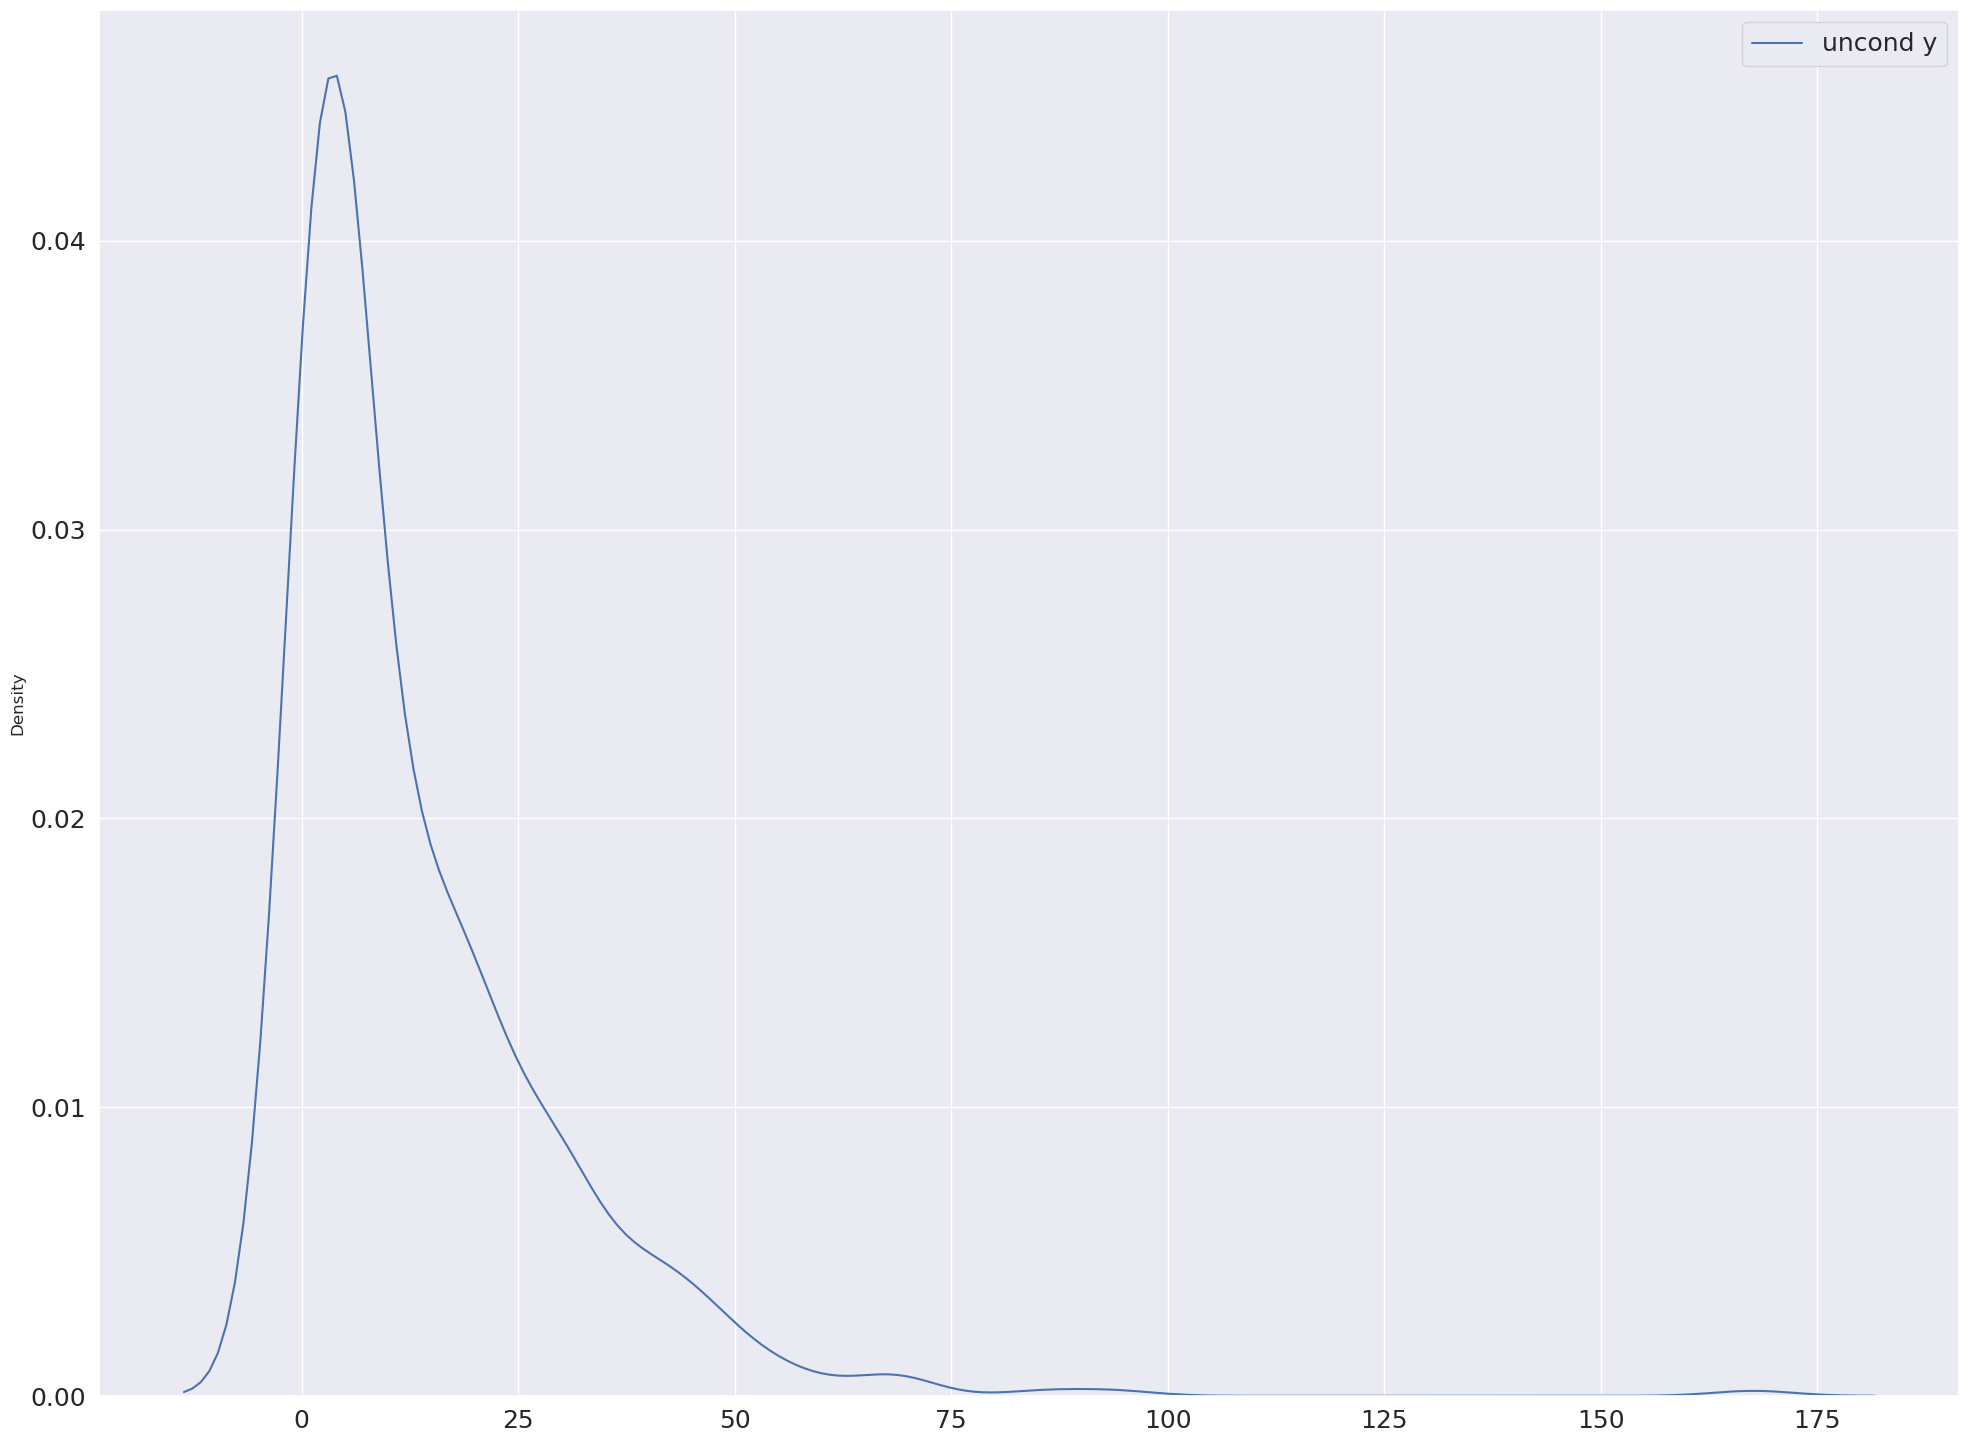

In [4]:
sns.kdeplot(dataset_y.view(-1).detach().cpu().numpy(), label = 'uncond y')
plt.legend()

In [5]:


dataset_x=dataset_x.to(device)
dataset_y=dataset_y.to(device)

x_min, x_max = dataset_x.min(), dataset_x.max()
y_min, y_max = dataset_y.min(), dataset_y.max()




In [6]:
x_normalized = (dataset_x - x_min) / (x_max - x_min) +0.01
y_normalized = (dataset_y - y_min) / (y_max - y_min) +0.01

In [7]:
x_normalized_transformed = transform(x_normalized/1.02).float().to(device)
y_normalized_transformed = transform(y_normalized/1.02).float().to(device)

In [8]:
num_steps = 1000
betas=make_beta_schedule(schedule="linear", num_timesteps=num_steps,start=1e-4, end=2e-2)
alphas=1-betas
alphas_bar=torch.cumprod(alphas,0).to(device)
alphas_bar_sqrt=torch.sqrt(alphas_bar)
one_minus_alphas_bar_sqrt=torch.sqrt(1-alphas_bar)

In [9]:
val_index = 450
dataloader = torch.utils.data.DataLoader(torch.cat([x_normalized_transformed[:val_index,:], y_normalized_transformed[:val_index,:]], dim=1), 
                                         batch_size=9999,shuffle=True, )

x_val = x_normalized_transformed[val_index:,:]
y_val = y_normalized_transformed[val_index:,:]

In [10]:
model = DiffusionModelWithEmbedding(input_dim=dataset_y.shape[1], 
                                time_steps=num_steps, embedding_dim=32,
                                cond_dim=dz,hidden_dim=16).to(device)

In [11]:
import copy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epoch = 2000

ema2 = EMA(model)

best_val_loss = float("inf")

# ✅ 用来存最优模型参数（在内存里）
best_model_state = None
best_ema_state = None


for epoch in range(num_epoch):

    # ============================
    # Training
    # ============================
    model.train()
    total_train_loss = 0

    for idx, batch in enumerate(dataloader):

        batch_x = batch[:, :dz].to(device)
        batch_y = batch[:, dz:].to(device)

        loss = diffusion_loss_fn(
            model,
            batch_y,
            batch_x,
            alphas_bar_sqrt,
            one_minus_alphas_bar_sqrt,
            num_steps,
            device
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

        # EMA update
        ema2.update(model)

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(dataloader)

    # ============================
    # Validation
    # ============================
    model.eval()
    with torch.no_grad():

        val_loss = diffusion_loss_fn(
            model,
            y_val.to(device),
            x_val.to(device),
            alphas_bar_sqrt,
            one_minus_alphas_bar_sqrt,
            num_steps,
            device
        )

    val_loss_value = val_loss.item()

    # ============================
    # Keep best model in memory
    # ============================
    if val_loss_value < best_val_loss:

        best_val_loss = val_loss_value

        # ✅ 深拷贝参数（存在 RAM 里）
        best_model_state = copy.deepcopy(model.state_dict())
        best_ema_state = copy.deepcopy(ema2.state_dict())

        print(f"✅ Best model updated at epoch {epoch}, val_loss={best_val_loss:.6f}")

    # ============================
    # Logging
    # ============================
    print(f"Epoch [{epoch}/{num_epoch}] "
          f"Train Loss: {avg_train_loss:.6f} "
          f"Val Loss: {val_loss_value:.6f}")


model.load_state_dict(best_model_state)
ema2.load_state_dict(best_ema_state)

print("🎉 Training finished!")
print("✅ Best model restored from memory")
print("Best Val Loss =", best_val_loss)

✅ Best model updated at epoch 0, val_loss=1.112015
Epoch [0/2000] Train Loss: 1.114685 Val Loss: 1.112015
✅ Best model updated at epoch 1, val_loss=0.768502
Epoch [1/2000] Train Loss: 1.011211 Val Loss: 0.768502
Epoch [2/2000] Train Loss: 0.966542 Val Loss: 1.126747
Epoch [3/2000] Train Loss: 1.007012 Val Loss: 1.344761
Epoch [4/2000] Train Loss: 0.981575 Val Loss: 0.880447
Epoch [5/2000] Train Loss: 1.089644 Val Loss: 0.925520
Epoch [6/2000] Train Loss: 1.029184 Val Loss: 0.960461
Epoch [7/2000] Train Loss: 0.914062 Val Loss: 1.060158
✅ Best model updated at epoch 8, val_loss=0.732626
Epoch [8/2000] Train Loss: 0.961608 Val Loss: 0.732626
Epoch [9/2000] Train Loss: 0.870942 Val Loss: 0.928883
Epoch [10/2000] Train Loss: 0.860572 Val Loss: 1.086380
Epoch [11/2000] Train Loss: 0.815041 Val Loss: 1.022845
Epoch [12/2000] Train Loss: 0.979203 Val Loss: 0.991309
Epoch [13/2000] Train Loss: 0.866172 Val Loss: 0.777092
✅ Best model updated at epoch 14, val_loss=0.513999
Epoch [14/2000] Train

In [12]:
y_seq_crt = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                    input_dim=y_normalized_transformed.shape[1],
                                    cond=torch.tensor(x_normalized_transformed).to(device).float(),
                                    alphas_bar_sqrt=alphas_bar_sqrt,
                                    one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                    betas=betas,
                                    num_steps=num_steps,
                                    device=device)

/tmp/ipykernel_2097188/1041496781.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(x_normalized_transformed).to(device).float(),


In [13]:
y_gen = inverse_to_original(y_seq_crt[-1],y_min,y_max)



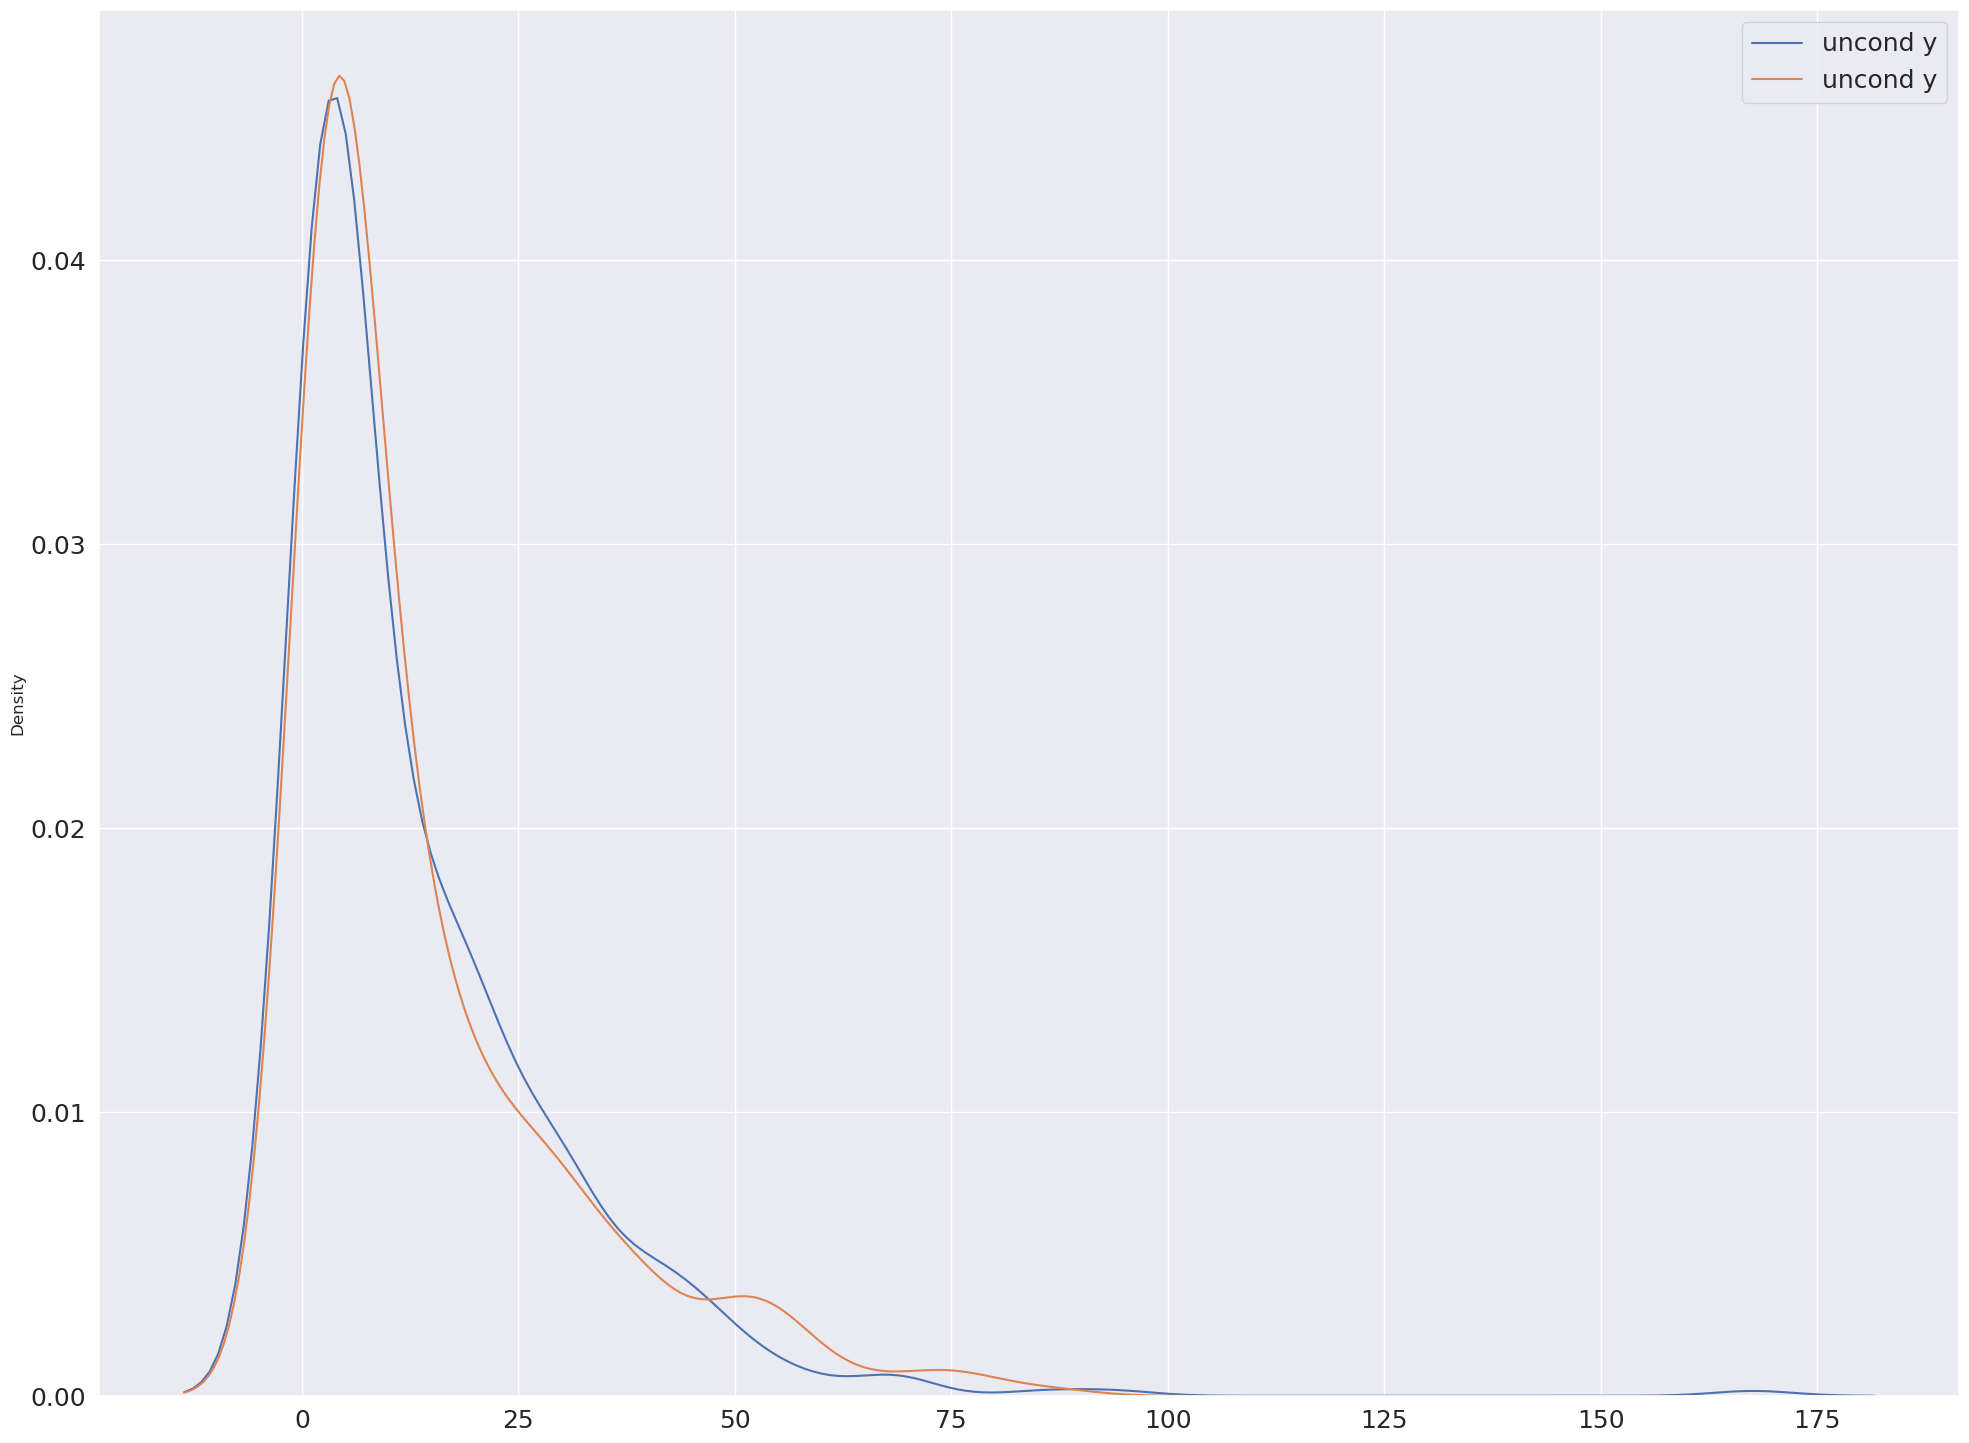

In [14]:
sns.kdeplot(dataset_y.view(-1).detach().cpu().numpy(), label = 'uncond y')
sns.kdeplot(y_gen.view(-1).detach().cpu().numpy(), label = 'uncond y')

plt.legend()

In [15]:
num_test = 500
z_fix=(torch.ones(num_test,dz)*torch.randn((1,dz))).to(device)
U_fix=np.random.binomial(n=1,p=0.5,size=num_test).reshape(num_test,1) 
U_fix=torch.from_numpy(U_fix).to(device)
rv_epsilon_fix=torch.zeros(size=(num_test,1)).to(device)
for i in range(0,len(U_fix)):
    if U_fix[i]<0.5:
        rv_epsilon_fix[i]=np.random.normal(-2,1)
    else:
        rv_epsilon_fix[i]=np.random.normal(2,1)

y_fix=(5+z_fix[:,0:1]**2/3+z_fix[:,1:2]**2+z_fix[:,2:3]**2+z_fix[:,3:4]+z_fix[:,4:5])*torch.exp(0.5*rv_epsilon_fix)



In [16]:
y_fix=y_fix.to(device)
z_fix_normalized = (z_fix - x_min) / (x_max - x_min) +0.01
z_fix_normalized_transformed = transform(z_fix_normalized/1.02).float().to(device)

y_seq = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                input_dim=y_fix.shape[1],
                                cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),
                                alphas_bar_sqrt=alphas_bar_sqrt,
                                one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                betas=betas,
                                num_steps=num_steps,
                                device=device)


/tmp/ipykernel_2097188/2147617884.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),


In [17]:
y_sorted = inverse_to_original(y_seq[-1],y_min,y_max).view(-1).sort().values

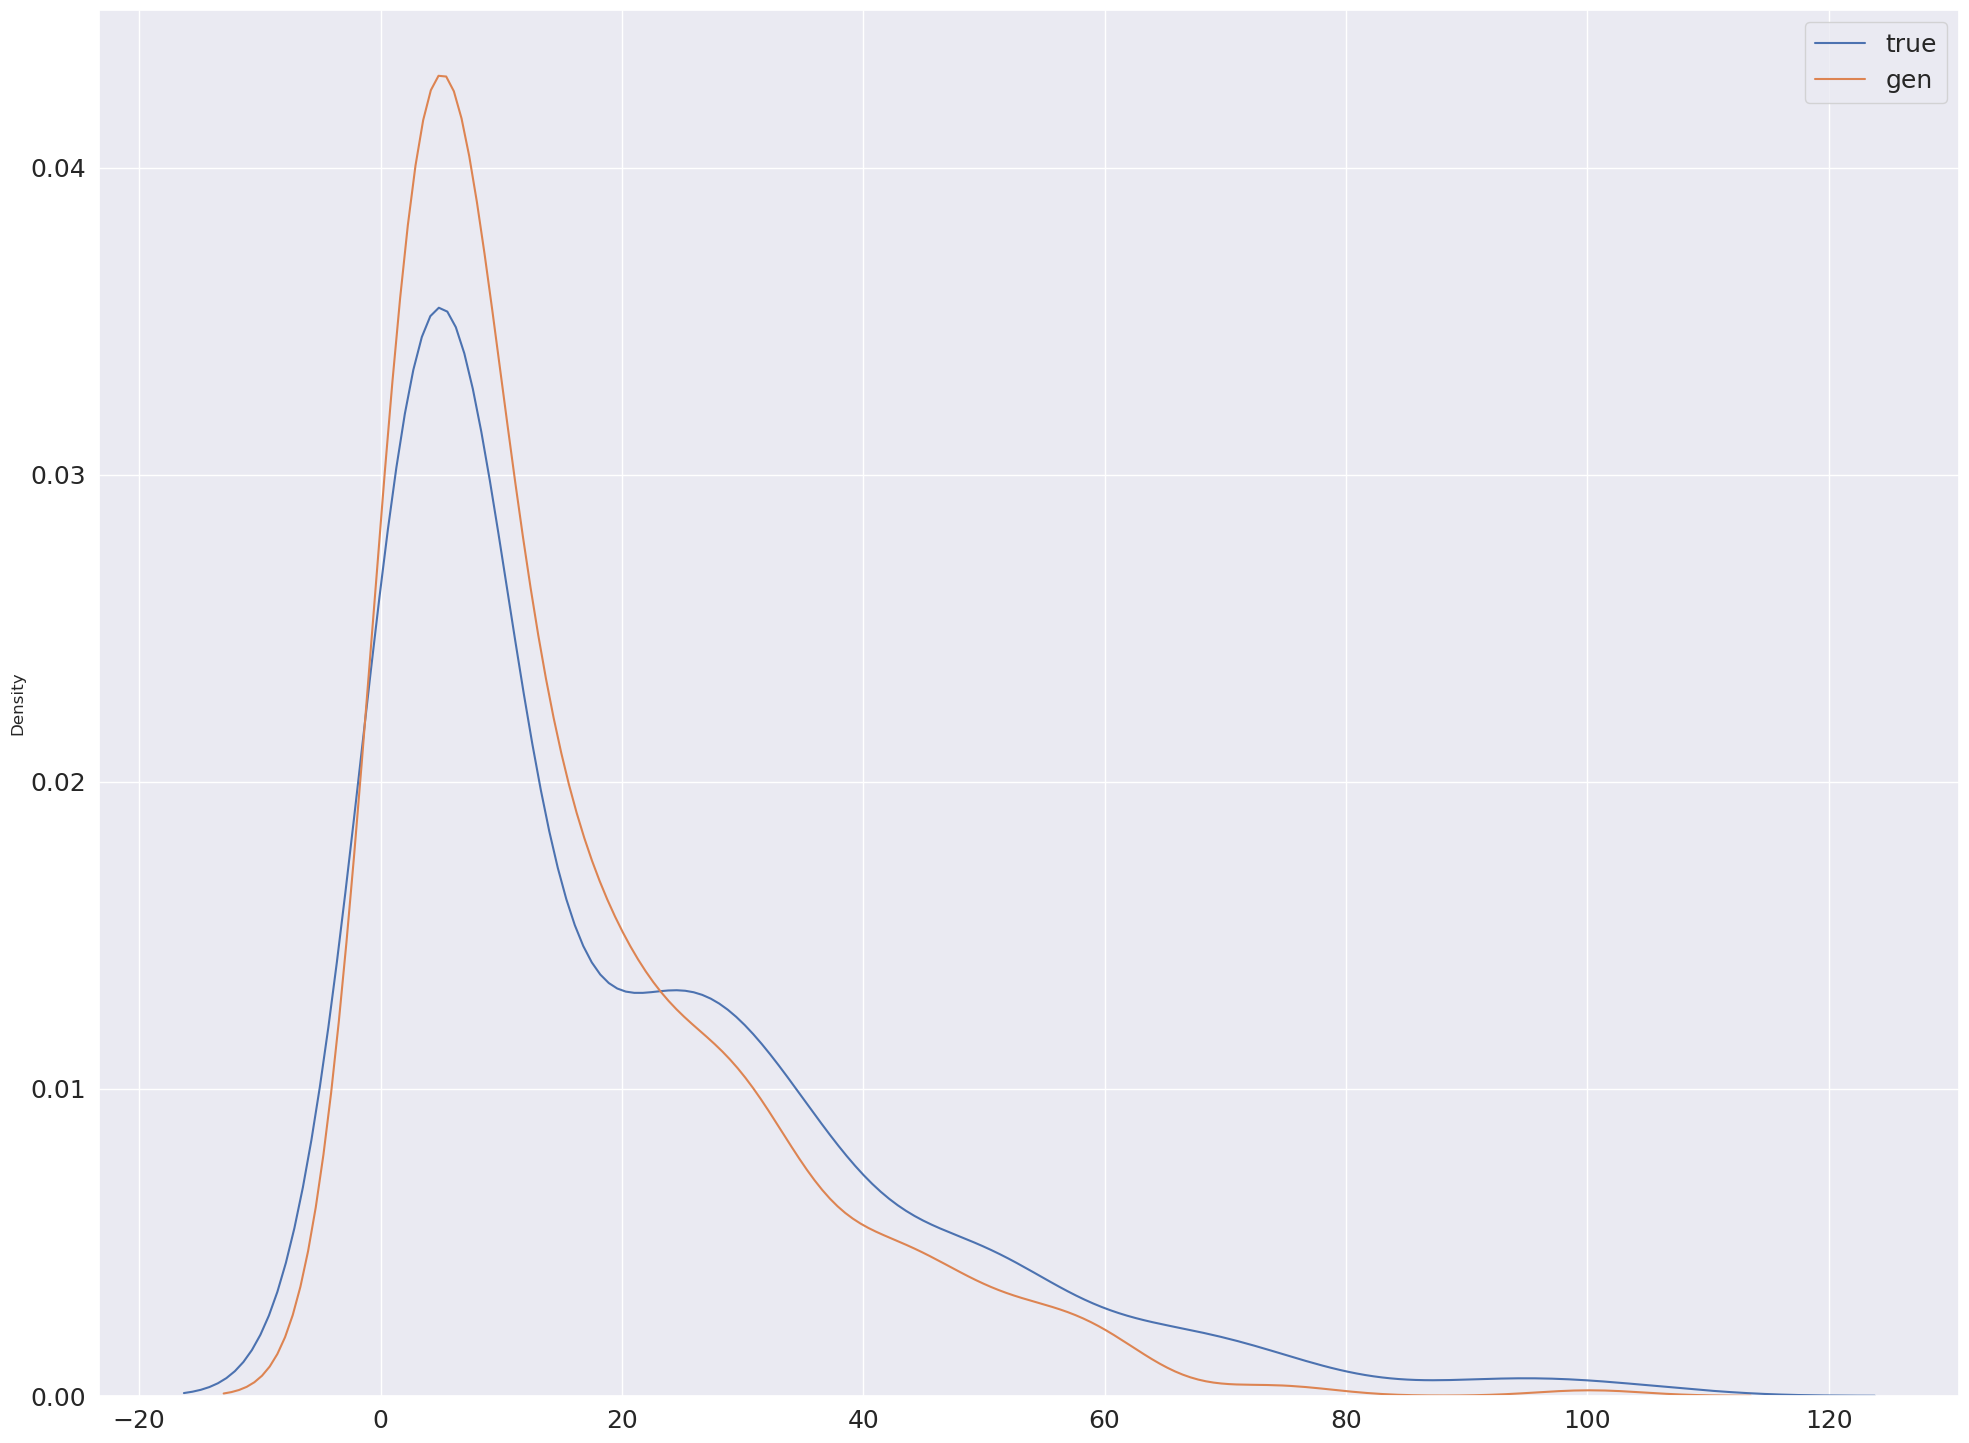

In [18]:
sns.kdeplot(y_fix.view(-1).detach().cpu().numpy(), label = 'true')
sns.kdeplot(y_sorted.view(-1).detach().cpu().numpy(), label = 'gen')
plt.legend()

In [24]:
quantile_005=0.05
quantile_025=0.25
quantile_050=0.50
quantile_075=0.75
quantile_095=0.95
result=[]
repeat=100
num_test=500
for i in range(repeat):
    seed_everything(i+40)
    print(i)
    z_fix=(torch.ones(num_test,dz)*torch.randn((1,dz))).to(device)
    U_fix=np.random.binomial(n=1,p=0.5,size=num_test).reshape(num_test,1) 
    U_fix=torch.from_numpy(U_fix).to(device)
    rv_epsilon_fix=torch.zeros(size=(num_test,1)).to(device)
    for i in range(0,len(U_fix)):
        if U_fix[i]<0.5:
            rv_epsilon_fix[i]=np.random.normal(-2,1)
        else:
            rv_epsilon_fix[i]=np.random.normal(2,1)

    y_fix=(5+z_fix[:,0:1]**2/3+z_fix[:,1:2]**2+z_fix[:,2:3]**2+z_fix[:,3:4]+z_fix[:,4:5])*torch.exp(0.5*rv_epsilon_fix)

    
    z_fix_normalized = (z_fix - x_min) / (x_max - x_min) +0.01
    z_fix_normalized_transformed = transform(z_fix_normalized/1.02).float().to(device)

    y_seq = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                    input_dim=y_fix.shape[1],
                                    cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),
                                    alphas_bar_sqrt=alphas_bar_sqrt,
                                    one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                    betas=betas,
                                    num_steps=num_steps,
                                    device=device)
    y_sorted = inverse_to_original(y_seq[-1],y_min,y_max).view(-1).sort().values
    #MSE of quantile
    x_sorted=(y_fix).view(-1).sort().values
    mse_005=(y_sorted[round(num_test*quantile_005)]-x_sorted[round(num_test*quantile_005)])**2
    mse_025=(y_sorted[round(num_test*quantile_025)]-x_sorted[round(num_test*quantile_025)])**2
    mse_050=(y_sorted[round(num_test*quantile_050)]-x_sorted[round(num_test*quantile_050)])**2
    mse_075=(y_sorted[round(num_test*quantile_075)]-x_sorted[round(num_test*quantile_075)])**2
    mse_095=(y_sorted[round(num_test*quantile_095)]-x_sorted[round(num_test*quantile_095)])**2
    result.append((mse_005.detach(),mse_025.detach(),mse_050.detach(),mse_075.detach(),mse_095.detach(),mse_005.detach()+mse_025.detach()+mse_050.detach()+mse_075.detach()+mse_095.detach()))
    print(result[-1][-1])

    
quantile_005_mse=0
quantile_025_mse=0
quantile_050_mse=0
quantile_075_mse=0
quantile_095_mse=0
quantile_total=0
for i in result:
    quantile_005_mse+=i[0]
    quantile_025_mse+=i[1]
    quantile_050_mse+=i[2]
    quantile_075_mse+=i[3]
    quantile_095_mse+=i[4]
    quantile_total+=i[5]
    
print(f'result:{quantile_005_mse/repeat,quantile_025_mse/repeat,quantile_050_mse/repeat,quantile_075_mse/repeat,quantile_095_mse/repeat,quantile_total/repeat}')

0


/tmp/ipykernel_2097188/38712409.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),


tensor(130.5212, device='cuda:0')
1
tensor(220.6175, device='cuda:0')
2
tensor(213.6671, device='cuda:0')
3
tensor(55.3653, device='cuda:0')
4
tensor(65.1082, device='cuda:0')
5
tensor(256.4395, device='cuda:0')
6
tensor(8.6772, device='cuda:0')
7
tensor(17.0533, device='cuda:0')
8
tensor(17.4952, device='cuda:0')
9
tensor(94.0377, device='cuda:0')
10
tensor(133.5853, device='cuda:0')
11
tensor(23.3667, device='cuda:0')
12
tensor(17.3500, device='cuda:0')
13
tensor(66.6743, device='cuda:0')
14
tensor(44.7172, device='cuda:0')
15
tensor(33.5566, device='cuda:0')
16
tensor(48.0365, device='cuda:0')
17
tensor(9.9992, device='cuda:0')
18
tensor(29.3043, device='cuda:0')
19
tensor(277.3202, device='cuda:0')
20
tensor(85.2081, device='cuda:0')
21
tensor(191.1281, device='cuda:0')
22
tensor(56.5611, device='cuda:0')
23
tensor(111.7314, device='cuda:0')
24
tensor(254.5983, device='cuda:0')
25
tensor(88.7078, device='cuda:0')
26
tensor(12.3694, device='cuda:0')
27
tensor(5.6122, device='cuda:0'

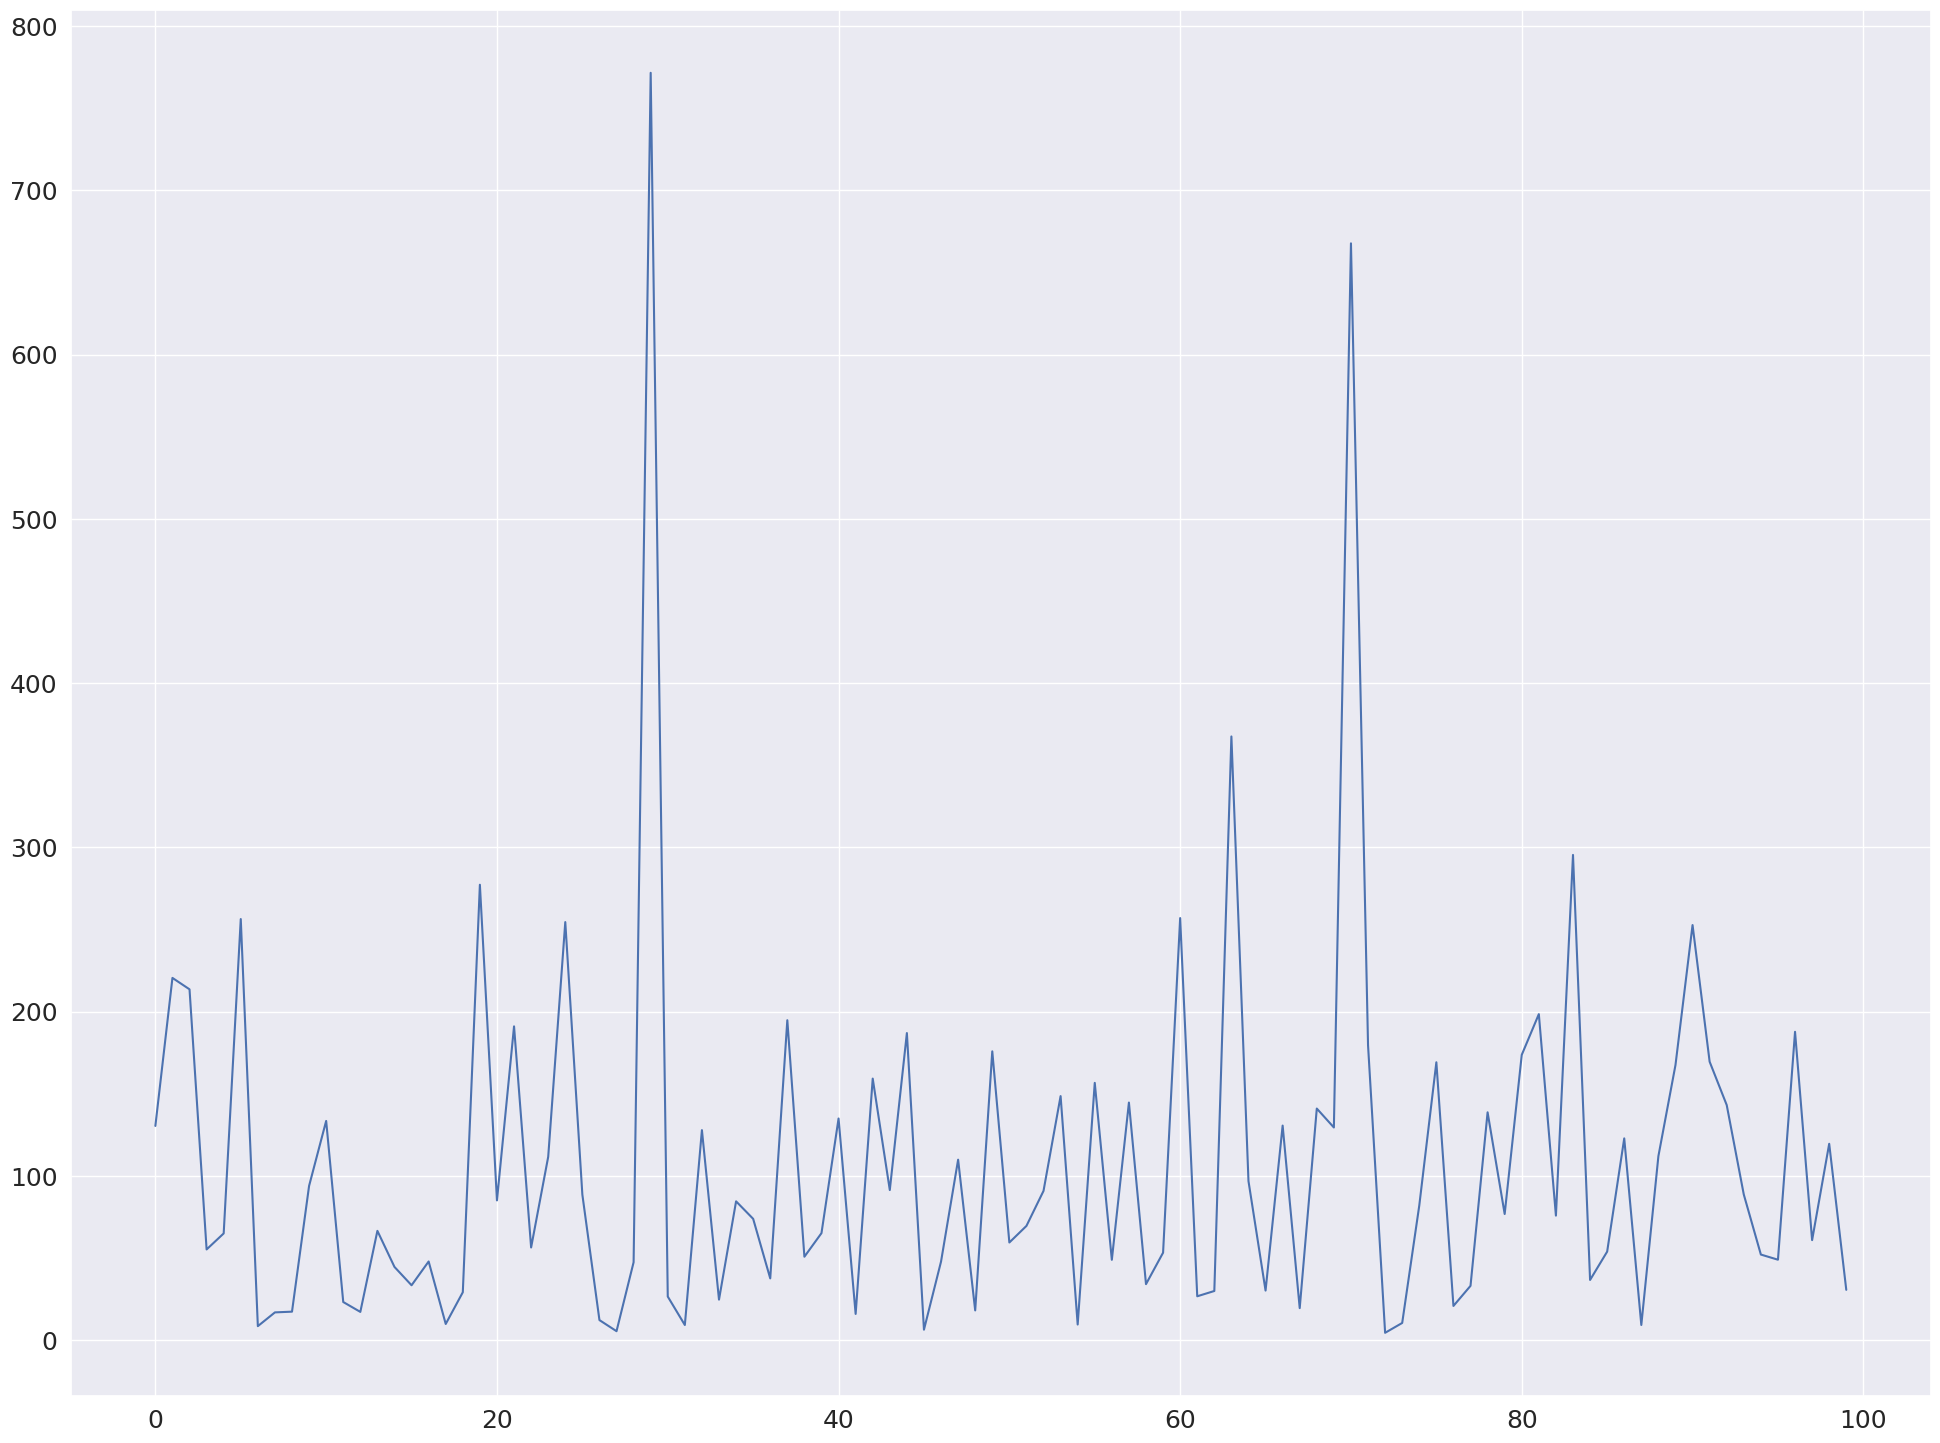

In [25]:
total_loss_list=[]
for i in result:
    total_loss_list.append(i[-1].detach().cpu())
plt.plot(total_loss_list)

In [26]:
result_std=torch.zeros((5,100))
for i in range(len(result)):
    result_std[0,i]=result[i][0].item()
    result_std[1,i]=result[i][1].item()
    result_std[2,i]=result[i][2].item()
    result_std[3,i]=result[i][3].item()
    result_std[4,i]=result[i][4].item()


In [27]:
result_std.std(dim=1)

tensor([  0.1237,   1.0966,  12.0557,  25.0286, 105.3390])